In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
# llm 설정
from langchain_openai import ChatOpenAI
from langchain_classic import hub
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_core.prompts import ChatPromptTemplate

rag_prompt = hub.pull("rlm/rag-prompt")

llm = ChatOpenAI(model="gpt-4o")
mini_llm = ChatOpenAI(model="gpt-4o-mini")

In [3]:
from typing import TypedDict


class AgentState(TypedDict):
    question: str
    answer: str
    context: list

In [6]:
from typing import Literal
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field

class Router(BaseModel):
    target: Literal['income_tax', 'real_estate_tax', 'llm'] = Field(description="The answer to the user's question")

router_system_prompt = """
You are an expert at routing a user's question to 'income_tax', 'real_estate_tax' or 'llm'

You are given a user's question and you need to return one of the following:
- "income_tax" if the question is about the income tax
- "real_estate_tax" if the question is about the real estate tax
- "llm" if the question is about the general knowledge

if you think the question is simple enough use 'llm'
"""

router_prompt = ChatPromptTemplate.from_messages([
    ("system", router_system_prompt),
    ("human", "{question}")
])

structured_router = mini_llm.with_structured_output(Router)

def router(state: AgentState):
    question = state["question"]
    router_chain = router_prompt | structured_router
    result = router_chain.invoke({"question": question})

    print(f"router answer: {result.target}")
    return result.target


In [ ]:
from langchain_core.output_parsers import StrOutputParser

def call_llm(state: AgentState):
    question = state["question"]
    llm_chain = mini_llm | StrOutputParser()
    answer = llm_chain.invoke(question)
    return {"answer": answer}

In [19]:
from langgraph.graph import StateGraph
from income_tax_graph import graph as income_tax_graph
from real_extate_tax_graph import graph as real_estate_tax_graph

graph_builder = StateGraph(AgentState)

graph_builder.add_node("income_tax_agent", income_tax_graph)
graph_builder.add_node("real_estate_tax_agent", real_estate_tax_graph)
graph_builder.add_node("llm", call_llm)


In [15]:
from langgraph.graph import START, END

graph_builder.add_conditional_edges(
    START,
    router,
    {
        "income_tax": "income_tax_agent",
        "real_estate_tax": "real_estate_tax_agent",
        "llm": "llm"
    }
)

graph_builder.add_edge("income_tax_agent", END)
graph_builder.add_edge("real_estate_tax_agent", END)
graph_builder.add_edge("llm", END)

graph = graph_builder.compile()

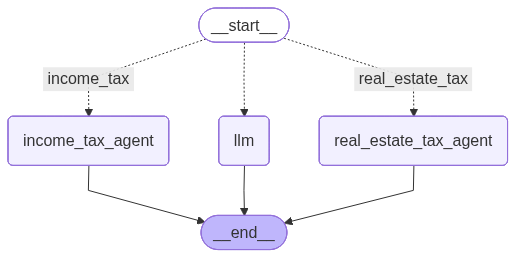

In [11]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [12]:
income_tax_state = {
    "question": "소득세란 무엇인가요?"
}

graph.invoke(income_tax_state)

router answer: income_tax
context: [Document(id='c8e3e91c-9df7-4d94-bde3-1e53c84c5dbd', metadata={'source': './documents/income_tax.txt'}, page_content='소득세법\n[시행 2025. 7. 1.] [법률 제20615호, 2024. 12. 31., 일부개정]\n기획재정부 (세제실) 044-215-4312\n기획재정부 (소득세과) 044-215-4216\n기획재정부 (음뷸세제과) 044-215-4233\n기획재정부 (소득세과(사무소), 기타소득) 044-215-4217  \n\n제1장 총칙\n제1조(목적)\n이 법은 개인의 소득에 대하여 소득의 성격과 납세자의 부담능력 등에 따라 적정하게 과세함으로써 세부담의 형평을 도모하고 재정수입의 원활한 조달에 이바지함을 목적으로 한다.\n[본조신설 2009. 12. 31.]\n[중전 제1조는 제2조로 이동 <2009. 12. 31.>]\n\n제2조(정의) ① 이 법에서 사용하는 용어의 뜻은 다음과 같다. <개정 2010. 12. 27, 2014. 12. 23, 2018. 12. 31.>\n\n“거주자”란 국내에 주소를 두거나 183일 이상의 거소(居所)를 둔 개인을 말한다.\n“비거주자”란 거주자가 아닌 개인을 말한다.\n“납세의무자”란 법인세법 제2조제1호에 따른 내국법인을 말한다.\n“외국법인”이란 법인세법 제2조제3호에 따른 외국법인을 말한다.\n“사업자”란 사업소득이 있는 거주자를 말한다.\n세법에 따른 소득ㆍ가소득자ㆍ비거주자의 구분은 대통령령으로 정한다.\n[본조신설 2009. 12. 31.]\n\n\n제2조의2(납세의무)\n구체적으로 다음 각 호의 어느 하나에 해당하는 개인은 이 법에 따라 각자의 소득에 대한 소득세를 납부할 의무를 진다.\n1. 거주자\n2. 비거주자\n3. 납세의무자\n4. 외국법인이 국내사업장(出張所), 그 밖에 이에 준하는 것을 포함한다. 이하 같다.\n5. 그 밖에 이 법

{'question': '소득세란 무엇인가요?',
 'answer': '소득세는 개인의 소득에 대해 소득의 성격과 납세자의 부담능력 등을 고려하여 과세하는 세금입니다. 이를 통해 세부담의 형평을 도모하고, 정부의 재정수입 조달에 기여하는 것을 목적으로 합니다.',
 'context': [Document(id='c8e3e91c-9df7-4d94-bde3-1e53c84c5dbd', metadata={'source': './documents/income_tax.txt'}, page_content='소득세법\n[시행 2025. 7. 1.] [법률 제20615호, 2024. 12. 31., 일부개정]\n기획재정부 (세제실) 044-215-4312\n기획재정부 (소득세과) 044-215-4216\n기획재정부 (음뷸세제과) 044-215-4233\n기획재정부 (소득세과(사무소), 기타소득) 044-215-4217  \n\n제1장 총칙\n제1조(목적)\n이 법은 개인의 소득에 대하여 소득의 성격과 납세자의 부담능력 등에 따라 적정하게 과세함으로써 세부담의 형평을 도모하고 재정수입의 원활한 조달에 이바지함을 목적으로 한다.\n[본조신설 2009. 12. 31.]\n[중전 제1조는 제2조로 이동 <2009. 12. 31.>]\n\n제2조(정의) ① 이 법에서 사용하는 용어의 뜻은 다음과 같다. <개정 2010. 12. 27, 2014. 12. 23, 2018. 12. 31.>\n\n“거주자”란 국내에 주소를 두거나 183일 이상의 거소(居所)를 둔 개인을 말한다.\n“비거주자”란 거주자가 아닌 개인을 말한다.\n“납세의무자”란 법인세법 제2조제1호에 따른 내국법인을 말한다.\n“외국법인”이란 법인세법 제2조제3호에 따른 외국법인을 말한다.\n“사업자”란 사업소득이 있는 거주자를 말한다.\n세법에 따른 소득ㆍ가소득자ㆍ비거주자의 구분은 대통령령으로 정한다.\n[본조신설 2009. 12. 31.]\n\n\n제2조의2(납세의무)\n구체적으로 다음 각 호의 어느 하나에 해당하는 개인은 

In [16]:
real_estate_tax_state = {
    "question": "집 15억은 세금을 얼마나 내나요?"
}

graph.invoke(real_estate_tax_state)

router answer: real_estate_tax
tax_deduction: 주택에 대한 종합부동산세 계산 시, 1세대 1주택자는 12억 원, 법인 또는 법인으로 보는 단체는 6억 원, 그 외의 경우는 9억 원이 공제됩니다.
tax_base_equation: 과세표준 = (공시가격의 합계 - 공제금액) × 공정시장가액비율


BadRequestError: Error code: 400 - {'error': {'message': "This model's maximum context length is 128000 tokens. However, your messages resulted in 228172 tokens. Please reduce the length of the messages.", 'type': 'invalid_request_error', 'param': 'messages', 'code': 'context_length_exceeded'}}

In [20]:
llm_state = {
    "question": "떡볶이 레시피는 무엇인가요?"
}

graph.invoke(llm_state)

router answer: llm


ValueError: Invalid input type <class 'dict'>. Must be a PromptValue, str, or list of BaseMessages.